# DeiT: Data-efficient Image Transformer

<img src='https://github.com/facebookresearch/deit/raw/main/.github/deit.png' width='640'>

# About this notebook
- PyTorch `DeiT`: `Data-efficient Image Transformer starter` code

  (Training baseline notebooks are [here](https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training/) and [here](http://https://www.kaggle.com/yasufuminakama/ranzcr-resnet200d-3-stage-training-step1).)
- TPU or GPU
- StratifiedKFold 5 folds
- 2019 + 2020 dataset


You can see other models.
 - Resnext50_32x4d
 - EfficientNet
 - ViT
 
 <img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbaskhR%2FbtqK3EYp1rv%2FZVqUwtt8aKfHTHdBQJLZgK%2Fimg.png' width='640'>
 
And also there are various Loss Functions
- CrossEntropyLoss
- FocalLoss
- FocalCosineLoss
- SymmetricCrossEntropyLoss
- BiTemperedLoss
- Taylor Cross Entropy Loss

https://www.kaggle.com/piantic/train-cassava-starter-using-various-loss-funcs

If this notebook is helpful, feel free to upvote :)

And please upvote the original notebook as well.


## Updated
**V5** - Add `Get_model()`

**V6** - Add `Taylor Cross Entropy Loss`
- Taylor Cross Entropy Loss

**V7** - Add `Auto Augment`
- Rand Augment

**V8** - Add `Scheduler`
- GradualWarmupSchedulerV2 - [link](https://www.kaggle.com/haqishen/baseline-modified-from-previous-competition)

**V10** - Add `Taylor Cross Entropy Loss with LabelSmoothingLoss` - [link](https://www.kaggle.com/yerramvarun/cassava-taylorce-loss-label-smoothing-combo)

**V12** - Add `CFG.smoothing` in `Taylor Cross Entropy Loss with LabelSmoothingLoss`

**V13** - Add `xm.set_rng_state(CFG.seed, device)` for reproducing results.(This requires more experimentation.)


# Directory settings

In [142]:
!pip install torch

In [143]:
# ====================================================
# Directory settings
# ====================================================
import pandas as pd
import seaborn as sns

import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
# TRAIN_PATH = '../input/cassava-leaf-disease-merged/train'
TEST_PATH = '../input/cassava-leaf-disease-classification/test_images'

# Data Loading

In [144]:
os.listdir('../input/cassava-leaf-disease-classification')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [145]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
# train_merged = pd.read_csv('../input/cassava-leaf-disease-merged/merged.csv')
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
label_map = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', 
                         orient='index')
display(label_map)

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


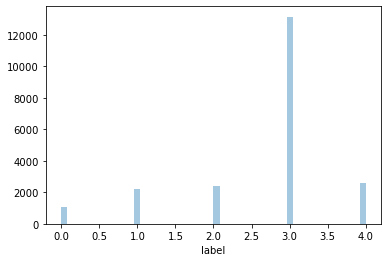

In [146]:
sns.distplot(train['label'], kde=False)

In [147]:
# sns.distplot(train_merged['label'], kde=False)

# CFG

In [148]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b3_ns' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b3_ns']
    size=224 # [224, 384, 512]
    freeze_epo = 0 # GradualWarmupSchedulerV2
    warmup_epo = 1 # GradualWarmupSchedulerV2
    cosine_epo = 19 # GradualWarmupSchedulerV2
    epochs = 10
#     epochs = freeze_epo + warmup_epo + cosine_epo # [GradualWarmupSchedulerV2, n_epochs]
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'GradualWarmupSchedulerV2']
    criterion='CrossEntropyLoss' # ['CrossEntropyLoss', LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr= 1e-4
    min_lr=1e-6
    batch_size=32 #[32, 64, 128]
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    rand_augment=False
    N=3 # RandAugment
    M=11 # RandAugment
    seed=42
    target_size=5
    target_col='label'
    n_fold=3
    trn_fold=[0,1, 2] #[0, 1, 2, 3, 4]
    train=True
    smoothing=0.05
    t1=0.3 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    t2=1.0 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [149]:
# !pip uninstall -y torch
# !pip install torch==1.8.2+cpu torchvision==0.9.2+cpu -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl (133.6 MB)


In [150]:
!pip install torchvision

In [151]:
if CFG.device == 'TPU':
    import os
    os.system('curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py')
    os.system('python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev')
    os.system('export XLA_USE_BF16=1')
    os.system('export XLA_TENSOR_ALLOCATOR_MAXSIZE=100000000')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.batch_size = CFG.batch_size // CFG.nprocs
    
!pip install --upgrade pip
if CFG.rand_augment:
    !pip install git+https://github.com/ildoonet/pytorch-randaugment > /dev/null
    from torchvision.transforms import transforms
    from RandAugment import RandAugment
    
if CFG.scheduler == 'GradualWarmupSchedulerV2': 
    !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git > /dev/null

# Library

In [152]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')


# ======================================
# Device - TPU or GPU
# ======================================

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU' and CFG.apex:
    from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [153]:
# If you want to use DeiT, please check timm version==0.3.2
# assert timm.__version__ == "0.3.2"

# Utils

In [154]:
# ====================================================
# Utils
# ====================================================

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [155]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         363
      1         729
      2         796
      3        4386
      4         859
1     0         362
      1         730
      2         795
      3        4386
      4         859
2     0         362
      1         730
      2         795
      3        4386
      4         859
dtype: int64


# Dataset

In [156]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TrainDataset_v2(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx]).long()
        return image, label

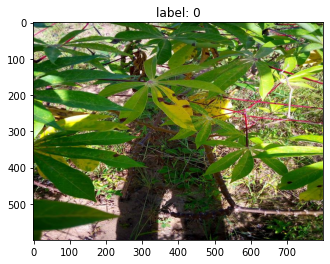

In [157]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [158]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            #Resize(CFG.size, CFG.size),
            A.RandomResizedCrop(CFG.size, CFG.size),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
def get_transforms_v2(*, data):
    
    if data == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop((CFG.size, CFG.size)),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            RandAugment(CFG.N, CFG.M),
            transforms.Resize((CFG.size, CFG.size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    elif data == 'valid':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((CFG.size, CFG.size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            
        ])

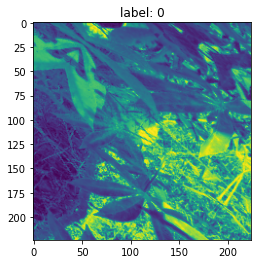

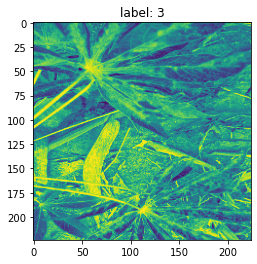

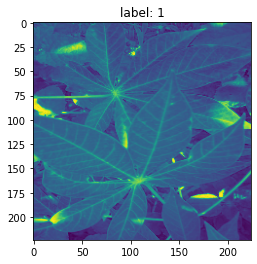

In [159]:
if CFG.rand_augment:
    train_dataset = TrainDataset_v2(train, transform=get_transforms_v2(data='train'))
else:
    train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(3):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [160]:
# ====================================================
# MODEL
# ====================================================
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    

class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

    
class CustomViT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [161]:
if CFG.model_name=='deit_base_patch16_224':
    model = CustomDeiT(model_name=CFG.model_name, pretrained=False)
elif CFG.model_name=='vit_base_patch16_384':
    model = CustomViT(model_name=CFG.model_name, pretrained=False)
elif CFG.model_name=='resnext50_32x4d':
    model = CustomResNext(CFG.model_name, pretrained=True)
elif CFG.model_name=='tf_efficientnet_b3_ns':
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    
if CFG.rand_augment:
    train_dataset = TrainDataset_v2(train, transform=get_transforms_v2(data='train'))
else:
    train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.1288,  0.0180, -0.0162, -0.0167,  0.0650],
        [ 0.0799,  0.0079, -0.0462,  0.0124,  0.0137],
        [-0.0762,  0.0350, -0.1943, -0.1861,  0.0390],
        [ 0.0604,  0.0138, -0.0516, -0.1771,  0.0693]],
       grad_fn=<AddmmBackward>)


# Criterion

## Label Smoothing

In [162]:
# ====================================================
# Label Smoothing
# ====================================================
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## Focal Loss

In [163]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## FocalCosineLoss

In [164]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss

## SymmetricCrossEntropy

In [165]:
class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes=5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].cuda()
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss

## Bi-Tempered-Loss

In [166]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

In [167]:
class BiTemperedLogisticLoss(nn.Module): 
    def __init__(self, t1, t2, smoothing=0.0): 
        super(BiTemperedLogisticLoss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing
    def forward(self, logit_label, truth_label):
        loss_label = bi_tempered_logistic_loss(
            logit_label, truth_label,
            t1=self.t1, t2=self.t2,
            label_smoothing=self.smoothing,
            reduction='none'
        )
        
        loss_label = loss_label.mean()
        return loss_label

## TaylorCrossEntropyLoss with Label Smoothing

In [168]:
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out


class TaylorCrossEntropyLoss(nn.Module):
    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.05):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.target_size, smoothing=smoothing)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        loss = self.lab_smooth(log_probs, labels)
        return loss

# Helper functions

## Scheduler

In [169]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [170]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

from torch.cuda.amp import autocast, GradScaler
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, labels)
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
        elif CFG.device == 'TPU':
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      #'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       #lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                #'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                #lr=scheduler.get_lr()[0],
                                ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# Train loop

In [171]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    if CFG.rand_augment:
        train_dataset = TrainDataset_v2(train_folds, 
                                 transform=get_transforms_v2(data='train'))
        valid_dataset = TrainDataset_v2(valid_folds, 
                                 transform=get_transforms_v2(data='valid'))
    else:
        train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    valid_labels = valid_folds[CFG.target_col].values
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='GradualWarmupSchedulerV2':
            scheduler_cosine=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.cosine_epo)
            scheduler_warmup=GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)
            scheduler=scheduler_warmup
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
        xm.set_rng_state(CFG.seed, device)
    elif CFG.device == 'GPU':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    def get_model(pretrained=False):
        if CFG.model_name=='deit_base_patch16_224':
            model = CustomDeiT(model_name=CFG.model_name, pretrained=pretrained)
        elif CFG.model_name=='vit_base_patch16_384':
            model = CustomViT(model_name=CFG.model_name, pretrained=pretrained)
        elif CFG.model_name=='resnext50_32x4d':
            model = CustomResNext(CFG.model_name, pretrained=pretrained)
        elif CFG.model_name=='tf_efficientnet_b3_ns':
            model = CustomEfficientNet(CFG.model_name, pretrained=pretrained)
        return model
    

    model = get_model(pretrained=True)    
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    #if CFG.apex:
    #    model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
        
        
    # ====================================================
    # Criterion - ['LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    # ====================================================
    
    def get_criterion():
        if CFG.criterion=='CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion=='LabelSmoothing':
            criterion = LabelSmoothingLoss(classes=CFG.target_size, smoothing=CFG.smoothing)
        elif CFG.criterion=='FocalLoss':
            criterion = FocalLoss().to(device)
        elif CFG.criterion=='FocalCosineLoss':
            criterion = FocalCosineLoss()
        elif CFG.criterion=='SymmetricCrossEntropyLoss':
            criterion = SymmetricCrossEntropy().to(device)
        elif CFG.criterion=='BiTemperedLoss':
            criterion = BiTemperedLogisticLoss(t1=CFG.t1, t2=CFG.t2, smoothing=CFG.smoothing)
        elif CFG.criterion=='TaylorCrossEntropyLoss':
            criterion = TaylorCrossEntropyLoss(smoothing=CFG.smoothing)
        return criterion


    # ====================================================
    # loop 
    # ====================================================
    criterion = get_criterion()
    LOGGER.info(f'Criterion: {criterion}')

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                avg_loss = train_fn(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        elif CFG.device == 'GPU':
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
                
        # eval
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            elif CFG.nprocs == 8:
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        elif CFG.device == 'GPU':
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, GradualWarmupSchedulerV2):
            scheduler.step(epoch)

        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
    
    if CFG.nprocs != 8:
        check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        valid_folds[[str(c) for c in range(5)]] = check_point['preds']
        valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [172]:
# ====================================================
# main
# ====================================================
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                if CFG.nprocs != 8:
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [173]:
if __name__ == '__main__':
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()


Epoch: [1][0/445] Data 1.163 (1.163) Elapsed 0m 1s (remain 12m 42s) Loss: 1.6153(1.6153) Grad: 144180.6562  
Epoch: [1][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 3s) Loss: 0.7649(1.0490) Grad: 136975.5469  
Epoch: [1][200/445] Data 0.009 (0.006) Elapsed 1m 10s (remain 1m 25s) Loss: 0.8278(0.9024) Grad: 204102.6719  
Epoch: [1][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.6152(0.8180) Grad: 169417.0781  
Epoch: [1][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.5383(0.7632) Grad: 169554.3906  
Epoch: [1][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.4671(0.7465) Grad: 165534.7656  
EVAL: [0/223] Data 1.204 (1.204) Elapsed 0m 1s (remain 4m 49s) Loss: 0.6091(0.6091) 
EVAL: [100/223] Data 0.636 (0.182) Elapsed 0m 25s (remain 0m 31s) Loss: 0.6917(0.5311) 
EVAL: [200/223] Data 0.658 (0.177) Elapsed 0m 50s (remain 0m 5s) Loss: 0.6844(0.5417) 


Epoch 1 - avg_train_loss: 0.7465  avg_val_loss: 0.5409  time: 209s
Epoch 1 - avg_train_loss: 0.7465  avg_val_loss: 0.5409  time: 209s
Epoch 1 - avg_train_loss: 0.7465  avg_val_loss: 0.5409  time: 209s
Epoch 1 - avg_train_loss: 0.7465  avg_val_loss: 0.5409  time: 209s
Epoch 1 - Score: 0.8095
Epoch 1 - Score: 0.8095
Epoch 1 - Score: 0.8095
Epoch 1 - Score: 0.8095
Epoch 1 - Save Best Score: 0.8095 Model
Epoch 1 - Save Best Score: 0.8095 Model
Epoch 1 - Save Best Score: 0.8095 Model
Epoch 1 - Save Best Score: 0.8095 Model


EVAL: [222/223] Data 0.000 (0.174) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4699(0.5409) 
Epoch: [2][0/445] Data 1.175 (1.175) Elapsed 0m 1s (remain 12m 35s) Loss: 0.6944(0.6944) Grad: 213339.6250  
Epoch: [2][100/445] Data 0.000 (0.012) Elapsed 0m 35s (remain 2m 2s) Loss: 0.5408(0.5721) Grad: 176151.8281  
Epoch: [2][200/445] Data 0.000 (0.006) Elapsed 1m 9s (remain 1m 24s) Loss: 0.3130(0.5422) Grad: 140143.3750  
Epoch: [2][300/445] Data 0.000 (0.004) Elapsed 1m 43s (remain 0m 49s) Loss: 0.4817(0.5332) Grad: 158176.2500  
Epoch: [2][400/445] Data 0.004 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.3693(0.5282) Grad: 145215.8594  
Epoch: [2][444/445] Data 0.000 (0.003) Elapsed 2m 31s (remain 0m 0s) Loss: 0.3873(0.5218) Grad: 136965.3438  
EVAL: [0/223] Data 1.372 (1.372) Elapsed 0m 1s (remain 5m 51s) Loss: 0.5955(0.5955) 
EVAL: [100/223] Data 0.580 (0.176) Elapsed 0m 25s (remain 0m 30s) Loss: 0.5685(0.4855) 
EVAL: [200/223] Data 0.165 (0.173) Elapsed 0m 49s (remain 0m 5s) Loss: 0.7109(0

Epoch 2 - avg_train_loss: 0.5218  avg_val_loss: 0.4934  time: 207s
Epoch 2 - avg_train_loss: 0.5218  avg_val_loss: 0.4934  time: 207s
Epoch 2 - avg_train_loss: 0.5218  avg_val_loss: 0.4934  time: 207s
Epoch 2 - avg_train_loss: 0.5218  avg_val_loss: 0.4934  time: 207s
Epoch 2 - Score: 0.8273
Epoch 2 - Score: 0.8273
Epoch 2 - Score: 0.8273
Epoch 2 - Score: 0.8273
Epoch 2 - Save Best Score: 0.8273 Model
Epoch 2 - Save Best Score: 0.8273 Model
Epoch 2 - Save Best Score: 0.8273 Model
Epoch 2 - Save Best Score: 0.8273 Model


EVAL: [222/223] Data 0.131 (0.172) Elapsed 0m 54s (remain 0m 0s) Loss: 0.4089(0.4934) 
Epoch: [3][0/445] Data 1.140 (1.140) Elapsed 0m 1s (remain 12m 21s) Loss: 0.3656(0.3656) Grad: 135747.7188  
Epoch: [3][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 2s) Loss: 0.3516(0.4963) Grad: 170090.4844  
Epoch: [3][200/445] Data 0.000 (0.006) Elapsed 1m 9s (remain 1m 24s) Loss: 0.2811(0.4740) Grad: 121279.1953  
Epoch: [3][300/445] Data 0.000 (0.004) Elapsed 1m 43s (remain 0m 49s) Loss: 0.2909(0.4793) Grad: 126023.8203  
Epoch: [3][400/445] Data 0.000 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.3835(0.4777) Grad: 133569.3125  
Epoch: [3][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.4685(0.4762) Grad: 174566.8281  
EVAL: [0/223] Data 1.244 (1.244) Elapsed 0m 1s (remain 4m 53s) Loss: 0.6021(0.6021) 
EVAL: [100/223] Data 0.324 (0.178) Elapsed 0m 25s (remain 0m 31s) Loss: 0.5682(0.4558) 
EVAL: [200/223] Data 0.657 (0.174) Elapsed 0m 50s (remain 0m 5s) Loss: 0.6701(0

Epoch 3 - avg_train_loss: 0.4762  avg_val_loss: 0.4626  time: 207s
Epoch 3 - avg_train_loss: 0.4762  avg_val_loss: 0.4626  time: 207s
Epoch 3 - avg_train_loss: 0.4762  avg_val_loss: 0.4626  time: 207s
Epoch 3 - avg_train_loss: 0.4762  avg_val_loss: 0.4626  time: 207s
Epoch 3 - Score: 0.8421
Epoch 3 - Score: 0.8421
Epoch 3 - Score: 0.8421
Epoch 3 - Score: 0.8421
Epoch 3 - Save Best Score: 0.8421 Model
Epoch 3 - Save Best Score: 0.8421 Model
Epoch 3 - Save Best Score: 0.8421 Model
Epoch 3 - Save Best Score: 0.8421 Model


EVAL: [222/223] Data 0.000 (0.170) Elapsed 0m 54s (remain 0m 0s) Loss: 0.4457(0.4626) 
Epoch: [4][0/445] Data 1.122 (1.122) Elapsed 0m 1s (remain 12m 1s) Loss: 0.3468(0.3468) Grad: 151253.3594  
Epoch: [4][100/445] Data 0.000 (0.012) Elapsed 0m 35s (remain 2m 1s) Loss: 0.2415(0.4319) Grad: 98402.2500  
Epoch: [4][200/445] Data 0.000 (0.006) Elapsed 1m 9s (remain 1m 24s) Loss: 0.2626(0.4456) Grad: 118056.3750  
Epoch: [4][300/445] Data 0.000 (0.004) Elapsed 1m 43s (remain 0m 49s) Loss: 0.3236(0.4462) Grad: 146979.0312  
Epoch: [4][400/445] Data 0.000 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.3788(0.4481) Grad: 148139.9531  
Epoch: [4][444/445] Data 0.000 (0.003) Elapsed 2m 31s (remain 0m 0s) Loss: 0.2196(0.4444) Grad: 89842.7891  
EVAL: [0/223] Data 1.278 (1.278) Elapsed 0m 1s (remain 4m 57s) Loss: 0.6346(0.6346) 
EVAL: [100/223] Data 0.000 (0.173) Elapsed 0m 25s (remain 0m 30s) Loss: 0.4758(0.4349) 
EVAL: [200/223] Data 0.000 (0.171) Elapsed 0m 49s (remain 0m 5s) Loss: 0.6424(0.44

Epoch 4 - avg_train_loss: 0.4444  avg_val_loss: 0.4431  time: 206s
Epoch 4 - avg_train_loss: 0.4444  avg_val_loss: 0.4431  time: 206s
Epoch 4 - avg_train_loss: 0.4444  avg_val_loss: 0.4431  time: 206s
Epoch 4 - avg_train_loss: 0.4444  avg_val_loss: 0.4431  time: 206s
Epoch 4 - Score: 0.8470
Epoch 4 - Score: 0.8470
Epoch 4 - Score: 0.8470
Epoch 4 - Score: 0.8470
Epoch 4 - Save Best Score: 0.8470 Model
Epoch 4 - Save Best Score: 0.8470 Model
Epoch 4 - Save Best Score: 0.8470 Model
Epoch 4 - Save Best Score: 0.8470 Model


EVAL: [222/223] Data 0.000 (0.169) Elapsed 0m 54s (remain 0m 0s) Loss: 0.5676(0.4431) 
Epoch: [5][0/445] Data 1.321 (1.321) Elapsed 0m 1s (remain 13m 30s) Loss: 0.6314(0.6314) Grad: 212105.9844  
Epoch: [5][100/445] Data 0.000 (0.014) Elapsed 0m 36s (remain 2m 4s) Loss: 0.3704(0.4259) Grad: 111371.2969  
Epoch: [5][200/445] Data 0.000 (0.007) Elapsed 1m 11s (remain 1m 26s) Loss: 0.3113(0.4166) Grad: 127927.7500  
Epoch: [5][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 50s) Loss: 0.3533(0.4147) Grad: 231906.1875  
Epoch: [5][400/445] Data 0.000 (0.004) Elapsed 2m 18s (remain 0m 15s) Loss: 0.3794(0.4111) Grad: 166183.9688  
Epoch: [5][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.1615(0.4161) Grad: 76429.1719  
EVAL: [0/223] Data 1.206 (1.206) Elapsed 0m 1s (remain 4m 43s) Loss: 0.6975(0.6975) 
EVAL: [100/223] Data 0.629 (0.182) Elapsed 0m 25s (remain 0m 31s) Loss: 0.4852(0.4483) 
EVAL: [200/223] Data 0.000 (0.177) Elapsed 0m 50s (remain 0m 5s) Loss: 0.5364(0

Epoch 5 - avg_train_loss: 0.4161  avg_val_loss: 0.4489  time: 209s
Epoch 5 - avg_train_loss: 0.4161  avg_val_loss: 0.4489  time: 209s
Epoch 5 - avg_train_loss: 0.4161  avg_val_loss: 0.4489  time: 209s
Epoch 5 - avg_train_loss: 0.4161  avg_val_loss: 0.4489  time: 209s
Epoch 5 - Score: 0.8482
Epoch 5 - Score: 0.8482
Epoch 5 - Score: 0.8482
Epoch 5 - Score: 0.8482
Epoch 5 - Save Best Score: 0.8482 Model
Epoch 5 - Save Best Score: 0.8482 Model
Epoch 5 - Save Best Score: 0.8482 Model
Epoch 5 - Save Best Score: 0.8482 Model


EVAL: [222/223] Data 0.098 (0.172) Elapsed 0m 55s (remain 0m 0s) Loss: 0.5075(0.4489) 
Epoch: [6][0/445] Data 1.272 (1.272) Elapsed 0m 1s (remain 13m 20s) Loss: 0.3973(0.3973) Grad: 167539.7812  
Epoch: [6][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 3s) Loss: 0.4157(0.4070) Grad: 175783.3125  
Epoch: [6][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.5888(0.4005) Grad: 214187.4375  
Epoch: [6][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 49s) Loss: 0.3785(0.3994) Grad: 151703.0938  
Epoch: [6][400/445] Data 0.000 (0.004) Elapsed 2m 18s (remain 0m 15s) Loss: 0.5665(0.3957) Grad: 203241.2969  
Epoch: [6][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.2130(0.3981) Grad: 131904.6719  
EVAL: [0/223] Data 1.196 (1.196) Elapsed 0m 1s (remain 4m 50s) Loss: 0.7032(0.7032) 
EVAL: [100/223] Data 0.993 (0.182) Elapsed 0m 26s (remain 0m 31s) Loss: 0.4909(0.4187) 
EVAL: [200/223] Data 0.661 (0.173) Elapsed 0m 50s (remain 0m 5s) Loss: 0.6169(

Epoch 6 - avg_train_loss: 0.3981  avg_val_loss: 0.4266  time: 208s
Epoch 6 - avg_train_loss: 0.3981  avg_val_loss: 0.4266  time: 208s
Epoch 6 - avg_train_loss: 0.3981  avg_val_loss: 0.4266  time: 208s
Epoch 6 - avg_train_loss: 0.3981  avg_val_loss: 0.4266  time: 208s
Epoch 6 - Score: 0.8580
Epoch 6 - Score: 0.8580
Epoch 6 - Score: 0.8580
Epoch 6 - Score: 0.8580
Epoch 6 - Save Best Score: 0.8580 Model
Epoch 6 - Save Best Score: 0.8580 Model
Epoch 6 - Save Best Score: 0.8580 Model
Epoch 6 - Save Best Score: 0.8580 Model


EVAL: [222/223] Data 0.000 (0.169) Elapsed 0m 54s (remain 0m 0s) Loss: 0.5173(0.4266) 
Epoch: [7][0/445] Data 1.173 (1.173) Elapsed 0m 2s (remain 15m 35s) Loss: 0.6262(0.6262) Grad: 176378.3594  
Epoch: [7][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 5s) Loss: 0.3274(0.3778) Grad: 163411.5938  
Epoch: [7][200/445] Data 0.000 (0.006) Elapsed 1m 11s (remain 1m 26s) Loss: 0.7037(0.3822) Grad: 228873.9375  
Epoch: [7][300/445] Data 0.000 (0.004) Elapsed 1m 45s (remain 0m 50s) Loss: 0.2190(0.3922) Grad: 120714.1875  
Epoch: [7][400/445] Data 0.000 (0.003) Elapsed 2m 19s (remain 0m 15s) Loss: 0.4954(0.3886) Grad: 162888.5312  
Epoch: [7][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.2786(0.3878) Grad: 163399.8281  
EVAL: [0/223] Data 1.233 (1.233) Elapsed 0m 1s (remain 4m 55s) Loss: 0.6886(0.6886) 
EVAL: [100/223] Data 0.686 (0.185) Elapsed 0m 26s (remain 0m 31s) Loss: 0.5004(0.4208) 
EVAL: [200/223] Data 0.651 (0.175) Elapsed 0m 50s (remain 0m 5s) Loss: 0.6183(

Epoch 7 - avg_train_loss: 0.3878  avg_val_loss: 0.4259  time: 209s
Epoch 7 - avg_train_loss: 0.3878  avg_val_loss: 0.4259  time: 209s
Epoch 7 - avg_train_loss: 0.3878  avg_val_loss: 0.4259  time: 209s
Epoch 7 - avg_train_loss: 0.3878  avg_val_loss: 0.4259  time: 209s
Epoch 7 - Score: 0.8545
Epoch 7 - Score: 0.8545
Epoch 7 - Score: 0.8545
Epoch 7 - Score: 0.8545


EVAL: [222/223] Data 0.000 (0.171) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4944(0.4259) 
Epoch: [8][0/445] Data 1.234 (1.234) Elapsed 0m 1s (remain 12m 17s) Loss: 0.4723(0.4723) Grad: 160945.7812  
Epoch: [8][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 4s) Loss: 0.2135(0.3710) Grad: 120597.4766  
Epoch: [8][200/445] Data 0.000 (0.006) Elapsed 1m 10s (remain 1m 25s) Loss: 0.2785(0.3579) Grad: 160942.3906  
Epoch: [8][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.4252(0.3580) Grad: 202709.9375  
Epoch: [8][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.3331(0.3610) Grad: 125421.8984  
Epoch: [8][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.4473(0.3620) Grad: 184181.7656  
EVAL: [0/223] Data 1.076 (1.076) Elapsed 0m 1s (remain 4m 22s) Loss: 0.7395(0.7395) 
EVAL: [100/223] Data 0.532 (0.182) Elapsed 0m 26s (remain 0m 31s) Loss: 0.5292(0.4219) 
EVAL: [200/223] Data 1.442 (0.178) Elapsed 0m 51s (remain 0m 5s) Loss: 0.6360(

Epoch 8 - avg_train_loss: 0.3620  avg_val_loss: 0.4288  time: 209s
Epoch 8 - avg_train_loss: 0.3620  avg_val_loss: 0.4288  time: 209s
Epoch 8 - avg_train_loss: 0.3620  avg_val_loss: 0.4288  time: 209s
Epoch 8 - avg_train_loss: 0.3620  avg_val_loss: 0.4288  time: 209s
Epoch 8 - Score: 0.8560
Epoch 8 - Score: 0.8560
Epoch 8 - Score: 0.8560
Epoch 8 - Score: 0.8560


EVAL: [222/223] Data 0.000 (0.173) Elapsed 0m 55s (remain 0m 0s) Loss: 0.5112(0.4288) 
Epoch: [9][0/445] Data 1.114 (1.114) Elapsed 0m 1s (remain 12m 23s) Loss: 0.3979(0.3979) Grad: 190946.4219  
Epoch: [9][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 4s) Loss: 0.3984(0.3687) Grad: 238730.9844  
Epoch: [9][200/445] Data 0.001 (0.006) Elapsed 1m 10s (remain 1m 25s) Loss: 0.9708(0.3725) Grad: 278437.4062  
Epoch: [9][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.2054(0.3663) Grad: 127750.2578  
Epoch: [9][400/445] Data 0.000 (0.003) Elapsed 2m 19s (remain 0m 15s) Loss: 0.3150(0.3649) Grad: 140531.7031  
Epoch: [9][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.4135(0.3649) Grad: 176907.1562  
EVAL: [0/223] Data 1.176 (1.176) Elapsed 0m 1s (remain 4m 40s) Loss: 0.7942(0.7942) 
EVAL: [100/223] Data 0.000 (0.173) Elapsed 0m 25s (remain 0m 30s) Loss: 0.5256(0.4151) 
EVAL: [200/223] Data 0.000 (0.170) Elapsed 0m 49s (remain 0m 5s) Loss: 0.6253(

Epoch 10 - avg_train_loss: 0.3556  avg_val_loss: 0.4223  time: 210s
Epoch 10 - avg_train_loss: 0.3556  avg_val_loss: 0.4223  time: 210s
Epoch 10 - avg_train_loss: 0.3556  avg_val_loss: 0.4223  time: 210s
Epoch 10 - avg_train_loss: 0.3556  avg_val_loss: 0.4223  time: 210s
Epoch 10 - Score: 0.8567
Epoch 10 - Score: 0.8567
Epoch 10 - Score: 0.8567
Epoch 10 - Score: 0.8567


EVAL: [222/223] Data 0.000 (0.172) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4853(0.4223) 


========== fold: 0 result ==========
========== fold: 0 result ==========
========== fold: 0 result ==========
========== fold: 0 result ==========
Score: 0.85812
Score: 0.85812
Score: 0.85812
Score: 0.85812
========== fold: 1 training ==========
========== fold: 1 training ==========
========== fold: 1 training ==========
========== fold: 1 training ==========
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()


Epoch: [1][0/445] Data 1.235 (1.235) Elapsed 0m 1s (remain 13m 17s) Loss: 1.5880(1.5880) Grad: 146089.2500  
Epoch: [1][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 4s) Loss: 0.9372(1.0539) Grad: 201560.6250  
Epoch: [1][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.4065(0.9043) Grad: 121898.3516  
Epoch: [1][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 50s) Loss: 0.6035(0.8191) Grad: 195801.9531  
Epoch: [1][400/445] Data 0.000 (0.004) Elapsed 2m 19s (remain 0m 15s) Loss: 0.7266(0.7610) Grad: 183650.8438  
Epoch: [1][444/445] Data 0.000 (0.003) Elapsed 2m 34s (remain 0m 0s) Loss: 0.4706(0.7422) Grad: 185919.9844  
EVAL: [0/223] Data 1.217 (1.217) Elapsed 0m 1s (remain 5m 9s) Loss: 0.5068(0.5068) 
EVAL: [100/223] Data 0.463 (0.180) Elapsed 0m 26s (remain 0m 31s) Loss: 0.5751(0.5422) 
EVAL: [200/223] Data 0.198 (0.174) Elapsed 0m 50s (remain 0m 5s) Loss: 0.5705(0.5391) 


Epoch 1 - avg_train_loss: 0.7422  avg_val_loss: 0.5424  time: 210s
Epoch 1 - avg_train_loss: 0.7422  avg_val_loss: 0.5424  time: 210s
Epoch 1 - avg_train_loss: 0.7422  avg_val_loss: 0.5424  time: 210s
Epoch 1 - avg_train_loss: 0.7422  avg_val_loss: 0.5424  time: 210s
Epoch 1 - Score: 0.8045
Epoch 1 - Score: 0.8045
Epoch 1 - Score: 0.8045
Epoch 1 - Score: 0.8045
Epoch 1 - Save Best Score: 0.8045 Model
Epoch 1 - Save Best Score: 0.8045 Model
Epoch 1 - Save Best Score: 0.8045 Model
Epoch 1 - Save Best Score: 0.8045 Model


EVAL: [222/223] Data 0.000 (0.173) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4333(0.5424) 
Epoch: [2][0/445] Data 1.358 (1.358) Elapsed 0m 1s (remain 13m 32s) Loss: 0.4201(0.4201) Grad: 152271.8750  
Epoch: [2][100/445] Data 0.000 (0.014) Elapsed 0m 36s (remain 2m 3s) Loss: 0.8437(0.5656) Grad: 197017.2969  
Epoch: [2][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 26s) Loss: 0.5854(0.5576) Grad: 209994.2188  
Epoch: [2][300/445] Data 0.000 (0.005) Elapsed 1m 45s (remain 0m 50s) Loss: 0.5887(0.5406) Grad: 170072.7969  
Epoch: [2][400/445] Data 0.000 (0.004) Elapsed 2m 19s (remain 0m 15s) Loss: 0.4097(0.5259) Grad: 158040.3594  
Epoch: [2][444/445] Data 0.000 (0.004) Elapsed 2m 33s (remain 0m 0s) Loss: 0.2950(0.5222) Grad: 131967.6875  
EVAL: [0/223] Data 1.355 (1.355) Elapsed 0m 1s (remain 5m 24s) Loss: 0.5403(0.5403) 
EVAL: [100/223] Data 0.068 (0.178) Elapsed 0m 25s (remain 0m 31s) Loss: 0.4472(0.4809) 
EVAL: [200/223] Data 0.177 (0.173) Elapsed 0m 50s (remain 0m 5s) Loss: 0.4501(

Epoch 2 - avg_train_loss: 0.5222  avg_val_loss: 0.4718  time: 209s
Epoch 2 - avg_train_loss: 0.5222  avg_val_loss: 0.4718  time: 209s
Epoch 2 - avg_train_loss: 0.5222  avg_val_loss: 0.4718  time: 209s
Epoch 2 - avg_train_loss: 0.5222  avg_val_loss: 0.4718  time: 209s
Epoch 2 - Score: 0.8326
Epoch 2 - Score: 0.8326
Epoch 2 - Score: 0.8326
Epoch 2 - Score: 0.8326
Epoch 2 - Save Best Score: 0.8326 Model
Epoch 2 - Save Best Score: 0.8326 Model
Epoch 2 - Save Best Score: 0.8326 Model
Epoch 2 - Save Best Score: 0.8326 Model


Epoch: [3][0/445] Data 1.238 (1.238) Elapsed 0m 1s (remain 13m 12s) Loss: 0.4367(0.4367) Grad: 143134.6406  
Epoch: [3][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 3s) Loss: 0.4107(0.4900) Grad: 119608.5234  
Epoch: [3][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.3407(0.4893) Grad: 139059.5781  
Epoch: [3][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 50s) Loss: 0.4693(0.4765) Grad: 189279.4062  
Epoch: [3][400/445] Data 0.000 (0.004) Elapsed 2m 19s (remain 0m 15s) Loss: 0.4244(0.4758) Grad: 171997.2812  
Epoch: [3][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.6249(0.4767) Grad: 187996.7344  
EVAL: [0/223] Data 1.202 (1.202) Elapsed 0m 1s (remain 4m 48s) Loss: 0.5050(0.5050) 
EVAL: [100/223] Data 0.500 (0.182) Elapsed 0m 26s (remain 0m 31s) Loss: 0.4874(0.4597) 
EVAL: [200/223] Data 0.200 (0.175) Elapsed 0m 51s (remain 0m 5s) Loss: 0.4666(0.4467) 


Epoch 3 - avg_train_loss: 0.4767  avg_val_loss: 0.4485  time: 210s
Epoch 3 - avg_train_loss: 0.4767  avg_val_loss: 0.4485  time: 210s
Epoch 3 - avg_train_loss: 0.4767  avg_val_loss: 0.4485  time: 210s
Epoch 3 - avg_train_loss: 0.4767  avg_val_loss: 0.4485  time: 210s
Epoch 3 - Score: 0.8403
Epoch 3 - Score: 0.8403
Epoch 3 - Score: 0.8403
Epoch 3 - Score: 0.8403
Epoch 3 - Save Best Score: 0.8403 Model
Epoch 3 - Save Best Score: 0.8403 Model
Epoch 3 - Save Best Score: 0.8403 Model
Epoch 3 - Save Best Score: 0.8403 Model


EVAL: [222/223] Data 0.000 (0.172) Elapsed 0m 55s (remain 0m 0s) Loss: 0.3823(0.4485) 
Epoch: [4][0/445] Data 1.265 (1.265) Elapsed 0m 1s (remain 12m 54s) Loss: 0.3891(0.3891) Grad: 144547.0469  
Epoch: [4][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 3s) Loss: 0.6447(0.4446) Grad: 196102.4375  
Epoch: [4][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.4600(0.4434) Grad: 167994.3125  
Epoch: [4][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 49s) Loss: 0.5706(0.4398) Grad: 192406.6562  
Epoch: [4][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.3229(0.4369) Grad: 145748.6719  
Epoch: [4][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.5883(0.4412) Grad: 174132.7500  
EVAL: [0/223] Data 1.177 (1.177) Elapsed 0m 1s (remain 4m 39s) Loss: 0.4549(0.4549) 
EVAL: [100/223] Data 1.135 (0.180) Elapsed 0m 25s (remain 0m 31s) Loss: 0.5410(0.5158) 
EVAL: [200/223] Data 0.490 (0.172) Elapsed 0m 50s (remain 0m 5s) Loss: 0.4447(

Epoch 4 - avg_train_loss: 0.4412  avg_val_loss: 0.4954  time: 209s
Epoch 4 - avg_train_loss: 0.4412  avg_val_loss: 0.4954  time: 209s
Epoch 4 - avg_train_loss: 0.4412  avg_val_loss: 0.4954  time: 209s
Epoch 4 - avg_train_loss: 0.4412  avg_val_loss: 0.4954  time: 209s
Epoch 4 - Score: 0.8209
Epoch 4 - Score: 0.8209
Epoch 4 - Score: 0.8209
Epoch 4 - Score: 0.8209


EVAL: [222/223] Data 0.000 (0.170) Elapsed 0m 54s (remain 0m 0s) Loss: 0.4891(0.4954) 
Epoch: [5][0/445] Data 1.268 (1.268) Elapsed 0m 2s (remain 15m 47s) Loss: 0.2448(0.2448) Grad: 112012.8594  
Epoch: [5][100/445] Data 0.000 (0.013) Elapsed 0m 37s (remain 2m 6s) Loss: 0.1931(0.4192) Grad: 90863.8672  
Epoch: [5][200/445] Data 0.000 (0.007) Elapsed 1m 11s (remain 1m 26s) Loss: 0.5144(0.4192) Grad: 147374.8281  
Epoch: [5][300/445] Data 0.009 (0.005) Elapsed 1m 45s (remain 0m 50s) Loss: 0.7155(0.4253) Grad: 192944.2344  
Epoch: [5][400/445] Data 0.000 (0.004) Elapsed 2m 19s (remain 0m 15s) Loss: 0.3574(0.4283) Grad: 133122.8750  
Epoch: [5][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.3078(0.4280) Grad: 112876.4766  
EVAL: [0/223] Data 1.130 (1.130) Elapsed 0m 1s (remain 4m 44s) Loss: 0.3942(0.3942) 
EVAL: [100/223] Data 0.604 (0.177) Elapsed 0m 25s (remain 0m 31s) Loss: 0.5207(0.4452) 
EVAL: [200/223] Data 0.512 (0.173) Elapsed 0m 50s (remain 0m 5s) Loss: 0.4625(0

Epoch 5 - avg_train_loss: 0.4280  avg_val_loss: 0.4323  time: 209s
Epoch 5 - avg_train_loss: 0.4280  avg_val_loss: 0.4323  time: 209s
Epoch 5 - avg_train_loss: 0.4280  avg_val_loss: 0.4323  time: 209s
Epoch 5 - avg_train_loss: 0.4280  avg_val_loss: 0.4323  time: 209s
Epoch 5 - Score: 0.8479
Epoch 5 - Score: 0.8479
Epoch 5 - Score: 0.8479
Epoch 5 - Score: 0.8479
Epoch 5 - Save Best Score: 0.8479 Model
Epoch 5 - Save Best Score: 0.8479 Model
Epoch 5 - Save Best Score: 0.8479 Model
Epoch 5 - Save Best Score: 0.8479 Model


EVAL: [222/223] Data 0.000 (0.171) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4644(0.4323) 
Epoch: [6][0/445] Data 1.184 (1.184) Elapsed 0m 1s (remain 12m 20s) Loss: 0.4148(0.4148) Grad: 160059.2344  
Epoch: [6][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 3s) Loss: 0.2409(0.4029) Grad: 124819.3750  
Epoch: [6][200/445] Data 0.000 (0.006) Elapsed 1m 10s (remain 1m 25s) Loss: 0.2873(0.4062) Grad: 134324.4219  
Epoch: [6][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.4101(0.3993) Grad: 168945.5000  
Epoch: [6][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.4609(0.3944) Grad: 161425.2344  
Epoch: [6][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.5611(0.4000) Grad: 193395.9531  
EVAL: [0/223] Data 1.201 (1.201) Elapsed 0m 1s (remain 4m 49s) Loss: 0.4194(0.4194) 
EVAL: [100/223] Data 0.342 (0.179) Elapsed 0m 25s (remain 0m 31s) Loss: 0.4696(0.4480) 
EVAL: [200/223] Data 0.652 (0.175) Elapsed 0m 50s (remain 0m 5s) Loss: 0.4693(

Epoch 6 - avg_train_loss: 0.4000  avg_val_loss: 0.4356  time: 209s
Epoch 6 - avg_train_loss: 0.4000  avg_val_loss: 0.4356  time: 209s
Epoch 6 - avg_train_loss: 0.4000  avg_val_loss: 0.4356  time: 209s
Epoch 6 - avg_train_loss: 0.4000  avg_val_loss: 0.4356  time: 209s
Epoch 6 - Score: 0.8473
Epoch 6 - Score: 0.8473
Epoch 6 - Score: 0.8473
Epoch 6 - Score: 0.8473


EVAL: [222/223] Data 0.000 (0.173) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4848(0.4356) 
Epoch: [7][0/445] Data 1.250 (1.250) Elapsed 0m 1s (remain 12m 35s) Loss: 0.0926(0.0926) Grad: 57702.2578  
Epoch: [7][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 3s) Loss: 0.4261(0.3587) Grad: 171394.7969  
Epoch: [7][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.3184(0.3780) Grad: 148015.8750  
Epoch: [7][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 49s) Loss: 0.2425(0.3843) Grad: 149953.8281  
Epoch: [7][400/445] Data 0.000 (0.004) Elapsed 2m 18s (remain 0m 15s) Loss: 0.5480(0.3831) Grad: 211942.5469  
Epoch: [7][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.4322(0.3799) Grad: 195267.4688  
EVAL: [0/223] Data 1.118 (1.118) Elapsed 0m 1s (remain 4m 34s) Loss: 0.3700(0.3700) 
EVAL: [100/223] Data 0.000 (0.174) Elapsed 0m 25s (remain 0m 30s) Loss: 0.5172(0.4439) 
EVAL: [200/223] Data 0.000 (0.175) Elapsed 0m 50s (remain 0m 5s) Loss: 0.4495(0

Epoch 7 - avg_train_loss: 0.3799  avg_val_loss: 0.4280  time: 209s
Epoch 7 - avg_train_loss: 0.3799  avg_val_loss: 0.4280  time: 209s
Epoch 7 - avg_train_loss: 0.3799  avg_val_loss: 0.4280  time: 209s
Epoch 7 - avg_train_loss: 0.3799  avg_val_loss: 0.4280  time: 209s
Epoch 7 - Score: 0.8511
Epoch 7 - Score: 0.8511
Epoch 7 - Score: 0.8511
Epoch 7 - Score: 0.8511
Epoch 7 - Save Best Score: 0.8511 Model
Epoch 7 - Save Best Score: 0.8511 Model
Epoch 7 - Save Best Score: 0.8511 Model
Epoch 7 - Save Best Score: 0.8511 Model


EVAL: [222/223] Data 0.000 (0.172) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4656(0.4280) 
Epoch: [8][0/445] Data 1.324 (1.324) Elapsed 0m 1s (remain 13m 13s) Loss: 0.2999(0.2999) Grad: 204885.8594  
Epoch: [8][100/445] Data 0.000 (0.014) Elapsed 0m 36s (remain 2m 4s) Loss: 0.2547(0.3631) Grad: 116685.9922  
Epoch: [8][200/445] Data 0.000 (0.007) Elapsed 1m 11s (remain 1m 27s) Loss: 0.3685(0.3604) Grad: 181365.9375  
Epoch: [8][300/445] Data 0.000 (0.005) Elapsed 1m 46s (remain 0m 50s) Loss: 0.4168(0.3601) Grad: 180044.6562  
Epoch: [8][400/445] Data 0.000 (0.004) Elapsed 2m 20s (remain 0m 15s) Loss: 0.2898(0.3653) Grad: 145352.0156  
Epoch: [8][444/445] Data 0.000 (0.003) Elapsed 2m 34s (remain 0m 0s) Loss: 0.5657(0.3664) Grad: 183461.9531  
EVAL: [0/223] Data 1.147 (1.147) Elapsed 0m 1s (remain 4m 33s) Loss: 0.4034(0.4034) 
EVAL: [100/223] Data 0.599 (0.183) Elapsed 0m 26s (remain 0m 31s) Loss: 0.4999(0.4437) 
EVAL: [200/223] Data 0.707 (0.180) Elapsed 0m 51s (remain 0m 5s) Loss: 0.3735(

Epoch 8 - avg_train_loss: 0.3664  avg_val_loss: 0.4329  time: 211s
Epoch 8 - avg_train_loss: 0.3664  avg_val_loss: 0.4329  time: 211s
Epoch 8 - avg_train_loss: 0.3664  avg_val_loss: 0.4329  time: 211s
Epoch 8 - avg_train_loss: 0.3664  avg_val_loss: 0.4329  time: 211s
Epoch 8 - Score: 0.8493
Epoch 8 - Score: 0.8493
Epoch 8 - Score: 0.8493
Epoch 8 - Score: 0.8493


EVAL: [222/223] Data 0.000 (0.175) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4561(0.4329) 
Epoch: [9][0/445] Data 1.134 (1.134) Elapsed 0m 1s (remain 12m 15s) Loss: 0.3072(0.3072) Grad: 148481.3906  
Epoch: [9][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 4s) Loss: 0.3187(0.3812) Grad: 156220.7969  
Epoch: [9][200/445] Data 0.000 (0.006) Elapsed 1m 11s (remain 1m 26s) Loss: 0.1752(0.3646) Grad: 91029.8125  
Epoch: [9][300/445] Data 0.000 (0.004) Elapsed 1m 45s (remain 0m 50s) Loss: 0.2314(0.3672) Grad: 133625.3750  
Epoch: [9][400/445] Data 0.000 (0.004) Elapsed 2m 19s (remain 0m 15s) Loss: 0.3590(0.3694) Grad: 158656.6406  
Epoch: [9][444/445] Data 0.000 (0.004) Elapsed 2m 34s (remain 0m 0s) Loss: 0.3243(0.3662) Grad: 128541.4766  
EVAL: [0/223] Data 1.201 (1.201) Elapsed 0m 1s (remain 4m 51s) Loss: 0.4142(0.4142) 
EVAL: [100/223] Data 0.299 (0.197) Elapsed 0m 27s (remain 0m 33s) Loss: 0.4898(0.4398) 
EVAL: [200/223] Data 0.640 (0.183) Elapsed 0m 51s (remain 0m 5s) Loss: 0.4195(0

Epoch 9 - avg_train_loss: 0.3662  avg_val_loss: 0.4282  time: 212s
Epoch 9 - avg_train_loss: 0.3662  avg_val_loss: 0.4282  time: 212s
Epoch 9 - avg_train_loss: 0.3662  avg_val_loss: 0.4282  time: 212s
Epoch 9 - avg_train_loss: 0.3662  avg_val_loss: 0.4282  time: 212s
Epoch 9 - Score: 0.8508
Epoch 9 - Score: 0.8508
Epoch 9 - Score: 0.8508
Epoch 9 - Score: 0.8508


EVAL: [222/223] Data 0.000 (0.181) Elapsed 0m 57s (remain 0m 0s) Loss: 0.4587(0.4282) 
Epoch: [10][0/445] Data 1.315 (1.315) Elapsed 0m 1s (remain 13m 23s) Loss: 0.4921(0.4921) Grad: 189314.1562  
Epoch: [10][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 3s) Loss: 0.3701(0.3236) Grad: 187651.9219  
Epoch: [10][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.3630(0.3464) Grad: 179901.1250  
Epoch: [10][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 49s) Loss: 0.3798(0.3453) Grad: 143201.3594  
Epoch: [10][400/445] Data 0.000 (0.004) Elapsed 2m 18s (remain 0m 15s) Loss: 0.5425(0.3462) Grad: 222602.6406  
Epoch: [10][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.4887(0.3488) Grad: 207754.2969  
EVAL: [0/223] Data 1.881 (1.881) Elapsed 0m 1s (remain 7m 18s) Loss: 0.3872(0.3872) 
EVAL: [100/223] Data 0.751 (0.187) Elapsed 0m 26s (remain 0m 31s) Loss: 0.4964(0.4430) 
EVAL: [200/223] Data 0.560 (0.181) Elapsed 0m 51s (remain 0m 5s) Loss: 0

Epoch 10 - avg_train_loss: 0.3488  avg_val_loss: 0.4301  time: 208s
Epoch 10 - avg_train_loss: 0.3488  avg_val_loss: 0.4301  time: 208s
Epoch 10 - avg_train_loss: 0.3488  avg_val_loss: 0.4301  time: 208s
Epoch 10 - avg_train_loss: 0.3488  avg_val_loss: 0.4301  time: 208s
Epoch 10 - Score: 0.8494
Epoch 10 - Score: 0.8494
Epoch 10 - Score: 0.8494
Epoch 10 - Score: 0.8494


EVAL: [222/223] Data 0.000 (0.176) Elapsed 0m 55s (remain 0m 0s) Loss: 0.4786(0.4301) 


========== fold: 1 result ==========
========== fold: 1 result ==========
========== fold: 1 result ==========
========== fold: 1 result ==========
Score: 0.85109
Score: 0.85109
Score: 0.85109
Score: 0.85109
========== fold: 2 training ==========
========== fold: 2 training ==========
========== fold: 2 training ==========
========== fold: 2 training ==========
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()
Criterion: CrossEntropyLoss()


Epoch: [1][0/445] Data 1.196 (1.196) Elapsed 0m 1s (remain 12m 20s) Loss: 1.6246(1.6246) Grad: 151481.2031  
Epoch: [1][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 3s) Loss: 1.0647(1.0549) Grad: 99147.2734  
Epoch: [1][200/445] Data 0.000 (0.006) Elapsed 1m 10s (remain 1m 25s) Loss: 0.7491(0.8938) Grad: 83539.4375  
Epoch: [1][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.6746(0.8066) Grad: 106399.6484  
Epoch: [1][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.8266(0.7522) Grad: 102342.6875  
Epoch: [1][444/445] Data 0.000 (0.003) Elapsed 2m 33s (remain 0m 0s) Loss: 0.3361(0.7347) Grad: 64343.6055  
EVAL: [0/223] Data 1.160 (1.160) Elapsed 0m 1s (remain 4m 42s) Loss: 0.7488(0.7488) 
EVAL: [100/223] Data 0.641 (0.178) Elapsed 0m 26s (remain 0m 31s) Loss: 0.6837(0.5729) 
EVAL: [200/223] Data 0.555 (0.175) Elapsed 0m 50s (remain 0m 5s) Loss: 0.3798(0.5636) 


Epoch 1 - avg_train_loss: 0.7347  avg_val_loss: 0.5622  time: 209s
Epoch 1 - avg_train_loss: 0.7347  avg_val_loss: 0.5622  time: 209s
Epoch 1 - avg_train_loss: 0.7347  avg_val_loss: 0.5622  time: 209s
Epoch 1 - avg_train_loss: 0.7347  avg_val_loss: 0.5622  time: 209s
Epoch 1 - Score: 0.7958
Epoch 1 - Score: 0.7958
Epoch 1 - Score: 0.7958
Epoch 1 - Score: 0.7958
Epoch 1 - Save Best Score: 0.7958 Model
Epoch 1 - Save Best Score: 0.7958 Model
Epoch 1 - Save Best Score: 0.7958 Model
Epoch 1 - Save Best Score: 0.7958 Model


EVAL: [222/223] Data 0.000 (0.171) Elapsed 0m 55s (remain 0m 0s) Loss: 0.3507(0.5622) 
Epoch: [2][0/445] Data 1.220 (1.220) Elapsed 0m 1s (remain 12m 41s) Loss: 0.6480(0.6480) Grad: 161506.3906  
Epoch: [2][100/445] Data 0.000 (0.013) Elapsed 0m 36s (remain 2m 2s) Loss: 0.6528(0.5184) Grad: 201273.8438  
Epoch: [2][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.4672(0.5156) Grad: 190571.6250  
Epoch: [2][300/445] Data 0.000 (0.005) Elapsed 1m 44s (remain 0m 49s) Loss: 0.4707(0.5192) Grad: 136178.8125  
Epoch: [2][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.4979(0.5172) Grad: 141873.9219  
Epoch: [2][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.3760(0.5173) Grad: 148890.6094  
EVAL: [0/223] Data 1.208 (1.208) Elapsed 0m 1s (remain 4m 46s) Loss: 0.5994(0.5994) 
EVAL: [100/223] Data 0.715 (0.175) Elapsed 0m 25s (remain 0m 30s) Loss: 0.5476(0.5210) 
EVAL: [200/223] Data 0.458 (0.173) Elapsed 0m 50s (remain 0m 5s) Loss: 0.3738(

Epoch 2 - avg_train_loss: 0.5173  avg_val_loss: 0.5181  time: 208s
Epoch 2 - avg_train_loss: 0.5173  avg_val_loss: 0.5181  time: 208s
Epoch 2 - avg_train_loss: 0.5173  avg_val_loss: 0.5181  time: 208s
Epoch 2 - avg_train_loss: 0.5173  avg_val_loss: 0.5181  time: 208s
Epoch 2 - Score: 0.8169
Epoch 2 - Score: 0.8169
Epoch 2 - Score: 0.8169
Epoch 2 - Score: 0.8169
Epoch 2 - Save Best Score: 0.8169 Model
Epoch 2 - Save Best Score: 0.8169 Model
Epoch 2 - Save Best Score: 0.8169 Model
Epoch 2 - Save Best Score: 0.8169 Model


EVAL: [222/223] Data 0.089 (0.169) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3551(0.5181) 
Epoch: [3][0/445] Data 1.192 (1.192) Elapsed 0m 1s (remain 13m 31s) Loss: 0.3603(0.3603) Grad: 147817.0781  
Epoch: [3][100/445] Data 0.001 (0.012) Elapsed 0m 36s (remain 2m 5s) Loss: 0.5650(0.4750) Grad: 171114.1719  
Epoch: [3][200/445] Data 0.000 (0.006) Elapsed 1m 10s (remain 1m 26s) Loss: 0.8725(0.4886) Grad: 238264.5938  
Epoch: [3][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.6756(0.4816) Grad: 230585.4688  
Epoch: [3][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.2987(0.4771) Grad: 138462.0312  
Epoch: [3][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.3663(0.4770) Grad: 148140.6875  
EVAL: [0/223] Data 1.143 (1.143) Elapsed 0m 1s (remain 4m 45s) Loss: 0.5299(0.5299) 
EVAL: [100/223] Data 0.000 (0.172) Elapsed 0m 25s (remain 0m 30s) Loss: 0.5031(0.5096) 
EVAL: [200/223] Data 0.000 (0.171) Elapsed 0m 49s (remain 0m 5s) Loss: 0.3961(

Epoch 3 - avg_train_loss: 0.4770  avg_val_loss: 0.5074  time: 208s
Epoch 3 - avg_train_loss: 0.4770  avg_val_loss: 0.5074  time: 208s
Epoch 3 - avg_train_loss: 0.4770  avg_val_loss: 0.5074  time: 208s
Epoch 3 - avg_train_loss: 0.4770  avg_val_loss: 0.5074  time: 208s
Epoch 3 - Score: 0.8155
Epoch 3 - Score: 0.8155
Epoch 3 - Score: 0.8155
Epoch 3 - Score: 0.8155


EVAL: [222/223] Data 0.118 (0.169) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3007(0.5074) 
Epoch: [4][0/445] Data 1.147 (1.147) Elapsed 0m 1s (remain 12m 22s) Loss: 0.6360(0.6360) Grad: 186221.7500  
Epoch: [4][100/445] Data 0.000 (0.012) Elapsed 0m 35s (remain 2m 2s) Loss: 0.5245(0.4505) Grad: 192987.4844  
Epoch: [4][200/445] Data 0.000 (0.006) Elapsed 1m 9s (remain 1m 24s) Loss: 0.3872(0.4399) Grad: 182499.0625  
Epoch: [4][300/445] Data 0.000 (0.004) Elapsed 1m 43s (remain 0m 49s) Loss: 0.4760(0.4539) Grad: 165737.7656  
Epoch: [4][400/445] Data 0.000 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.4244(0.4482) Grad: 172161.4688  
Epoch: [4][444/445] Data 0.000 (0.003) Elapsed 2m 31s (remain 0m 0s) Loss: 0.5426(0.4457) Grad: 181800.2031  
EVAL: [0/223] Data 1.208 (1.208) Elapsed 0m 1s (remain 4m 48s) Loss: 0.5473(0.5473) 
EVAL: [100/223] Data 0.288 (0.177) Elapsed 0m 25s (remain 0m 30s) Loss: 0.4697(0.4758) 
EVAL: [200/223] Data 0.400 (0.170) Elapsed 0m 49s (remain 0m 5s) Loss: 0.3431(0

Epoch 4 - avg_train_loss: 0.4457  avg_val_loss: 0.4801  time: 207s
Epoch 4 - avg_train_loss: 0.4457  avg_val_loss: 0.4801  time: 207s
Epoch 4 - avg_train_loss: 0.4457  avg_val_loss: 0.4801  time: 207s
Epoch 4 - avg_train_loss: 0.4457  avg_val_loss: 0.4801  time: 207s
Epoch 4 - Score: 0.8306
Epoch 4 - Score: 0.8306
Epoch 4 - Score: 0.8306
Epoch 4 - Score: 0.8306
Epoch 4 - Save Best Score: 0.8306 Model
Epoch 4 - Save Best Score: 0.8306 Model
Epoch 4 - Save Best Score: 0.8306 Model
Epoch 4 - Save Best Score: 0.8306 Model


EVAL: [222/223] Data 0.000 (0.169) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3360(0.4801) 
Epoch: [5][0/445] Data 1.197 (1.197) Elapsed 0m 1s (remain 12m 50s) Loss: 0.3450(0.3450) Grad: 168716.7812  
Epoch: [5][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 2s) Loss: 0.3322(0.4437) Grad: 177540.9531  
Epoch: [5][200/445] Data 0.000 (0.006) Elapsed 1m 9s (remain 1m 24s) Loss: 0.9853(0.4264) Grad: 268797.3750  
Epoch: [5][300/445] Data 0.000 (0.004) Elapsed 1m 43s (remain 0m 49s) Loss: 0.5406(0.4289) Grad: 185436.6406  
Epoch: [5][400/445] Data 0.000 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.6651(0.4280) Grad: 186323.3906  
Epoch: [5][444/445] Data 0.000 (0.003) Elapsed 2m 31s (remain 0m 0s) Loss: 0.3920(0.4281) Grad: 121143.9531  
EVAL: [0/223] Data 1.242 (1.242) Elapsed 0m 1s (remain 5m 3s) Loss: 0.4237(0.4237) 
EVAL: [100/223] Data 0.332 (0.183) Elapsed 0m 26s (remain 0m 31s) Loss: 0.4389(0.4606) 
EVAL: [200/223] Data 0.000 (0.175) Elapsed 0m 50s (remain 0m 5s) Loss: 0.2952(0.

Epoch 5 - avg_train_loss: 0.4281  avg_val_loss: 0.4614  time: 207s
Epoch 5 - avg_train_loss: 0.4281  avg_val_loss: 0.4614  time: 207s
Epoch 5 - avg_train_loss: 0.4281  avg_val_loss: 0.4614  time: 207s
Epoch 5 - avg_train_loss: 0.4281  avg_val_loss: 0.4614  time: 207s
Epoch 5 - Score: 0.8400
Epoch 5 - Score: 0.8400
Epoch 5 - Score: 0.8400
Epoch 5 - Score: 0.8400
Epoch 5 - Save Best Score: 0.8400 Model
Epoch 5 - Save Best Score: 0.8400 Model
Epoch 5 - Save Best Score: 0.8400 Model
Epoch 5 - Save Best Score: 0.8400 Model


EVAL: [222/223] Data 0.000 (0.171) Elapsed 0m 55s (remain 0m 0s) Loss: 0.3222(0.4614) 
Epoch: [6][0/445] Data 1.321 (1.321) Elapsed 0m 1s (remain 12m 57s) Loss: 0.3840(0.3840) Grad: 146361.4375  
Epoch: [6][100/445] Data 0.000 (0.014) Elapsed 0m 36s (remain 2m 3s) Loss: 0.7656(0.4064) Grad: 246026.6719  
Epoch: [6][200/445] Data 0.000 (0.007) Elapsed 1m 9s (remain 1m 24s) Loss: 0.4254(0.4156) Grad: 215800.7344  
Epoch: [6][300/445] Data 0.000 (0.005) Elapsed 1m 43s (remain 0m 49s) Loss: 0.2979(0.4144) Grad: 134787.0312  
Epoch: [6][400/445] Data 0.004 (0.004) Elapsed 2m 17s (remain 0m 15s) Loss: 0.4233(0.4132) Grad: 164353.9688  
Epoch: [6][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.5015(0.4145) Grad: 150906.3750  
EVAL: [0/223] Data 1.160 (1.160) Elapsed 0m 1s (remain 4m 44s) Loss: 0.4217(0.4217) 
EVAL: [100/223] Data 0.601 (0.183) Elapsed 0m 26s (remain 0m 31s) Loss: 0.4241(0.4651) 
EVAL: [200/223] Data 1.047 (0.177) Elapsed 0m 50s (remain 0m 5s) Loss: 0.3510(0

Epoch 6 - avg_train_loss: 0.4145  avg_val_loss: 0.4585  time: 208s
Epoch 6 - avg_train_loss: 0.4145  avg_val_loss: 0.4585  time: 208s
Epoch 6 - avg_train_loss: 0.4145  avg_val_loss: 0.4585  time: 208s
Epoch 6 - avg_train_loss: 0.4145  avg_val_loss: 0.4585  time: 208s
Epoch 6 - Score: 0.8418
Epoch 6 - Score: 0.8418
Epoch 6 - Score: 0.8418
Epoch 6 - Score: 0.8418
Epoch 6 - Save Best Score: 0.8418 Model
Epoch 6 - Save Best Score: 0.8418 Model
Epoch 6 - Save Best Score: 0.8418 Model
Epoch 6 - Save Best Score: 0.8418 Model


EVAL: [222/223] Data 0.072 (0.172) Elapsed 0m 55s (remain 0m 0s) Loss: 0.2907(0.4585) 
Epoch: [7][0/445] Data 1.195 (1.195) Elapsed 0m 1s (remain 12m 56s) Loss: 0.4620(0.4620) Grad: 188216.8906  
Epoch: [7][100/445] Data 0.000 (0.012) Elapsed 0m 35s (remain 2m 2s) Loss: 0.4411(0.4053) Grad: 166572.0156  
Epoch: [7][200/445] Data 0.000 (0.006) Elapsed 1m 9s (remain 1m 24s) Loss: 0.5189(0.3968) Grad: 238196.4219  
Epoch: [7][300/445] Data 0.000 (0.004) Elapsed 1m 43s (remain 0m 49s) Loss: 0.3277(0.3888) Grad: 164894.2500  
Epoch: [7][400/445] Data 0.000 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.5675(0.3951) Grad: 225903.6094  
Epoch: [7][444/445] Data 0.000 (0.003) Elapsed 2m 31s (remain 0m 0s) Loss: 0.4168(0.3913) Grad: 240005.9062  
EVAL: [0/223] Data 1.859 (1.859) Elapsed 0m 1s (remain 7m 14s) Loss: 0.4287(0.4287) 
EVAL: [100/223] Data 0.709 (0.180) Elapsed 0m 25s (remain 0m 31s) Loss: 0.4584(0.4559) 
EVAL: [200/223] Data 0.184 (0.174) Elapsed 0m 50s (remain 0m 5s) Loss: 0.3345(0

Epoch 7 - avg_train_loss: 0.3913  avg_val_loss: 0.4531  time: 207s
Epoch 7 - avg_train_loss: 0.3913  avg_val_loss: 0.4531  time: 207s
Epoch 7 - avg_train_loss: 0.3913  avg_val_loss: 0.4531  time: 207s
Epoch 7 - avg_train_loss: 0.3913  avg_val_loss: 0.4531  time: 207s
Epoch 7 - Score: 0.8437
Epoch 7 - Score: 0.8437
Epoch 7 - Score: 0.8437
Epoch 7 - Score: 0.8437
Epoch 7 - Save Best Score: 0.8437 Model
Epoch 7 - Save Best Score: 0.8437 Model
Epoch 7 - Save Best Score: 0.8437 Model
Epoch 7 - Save Best Score: 0.8437 Model


EVAL: [222/223] Data 0.000 (0.170) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3428(0.4531) 
Epoch: [8][0/445] Data 1.162 (1.162) Elapsed 0m 1s (remain 12m 19s) Loss: 0.2664(0.2664) Grad: 139452.2656  
Epoch: [8][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 3s) Loss: 0.3914(0.4017) Grad: 192053.2188  
Epoch: [8][200/445] Data 0.000 (0.006) Elapsed 1m 10s (remain 1m 25s) Loss: 0.3302(0.3891) Grad: 158445.2969  
Epoch: [8][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 50s) Loss: 0.2951(0.3903) Grad: 129717.4609  
Epoch: [8][400/445] Data 0.000 (0.003) Elapsed 2m 18s (remain 0m 15s) Loss: 0.5936(0.3884) Grad: 267326.6250  
Epoch: [8][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.2505(0.3895) Grad: 160097.0469  
EVAL: [0/223] Data 1.237 (1.237) Elapsed 0m 1s (remain 4m 51s) Loss: 0.4288(0.4288) 
EVAL: [100/223] Data 0.566 (0.179) Elapsed 0m 25s (remain 0m 30s) Loss: 0.4045(0.4563) 
EVAL: [200/223] Data 0.377 (0.175) Elapsed 0m 50s (remain 0m 5s) Loss: 0.3783(

Epoch 8 - avg_train_loss: 0.3895  avg_val_loss: 0.4499  time: 208s
Epoch 8 - avg_train_loss: 0.3895  avg_val_loss: 0.4499  time: 208s
Epoch 8 - avg_train_loss: 0.3895  avg_val_loss: 0.4499  time: 208s
Epoch 8 - avg_train_loss: 0.3895  avg_val_loss: 0.4499  time: 208s
Epoch 8 - Score: 0.8444
Epoch 8 - Score: 0.8444
Epoch 8 - Score: 0.8444
Epoch 8 - Score: 0.8444
Epoch 8 - Save Best Score: 0.8444 Model
Epoch 8 - Save Best Score: 0.8444 Model
Epoch 8 - Save Best Score: 0.8444 Model
Epoch 8 - Save Best Score: 0.8444 Model


EVAL: [222/223] Data 0.055 (0.170) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3019(0.4499) 
Epoch: [9][0/445] Data 1.267 (1.267) Elapsed 0m 1s (remain 12m 38s) Loss: 0.2429(0.2429) Grad: 170110.8594  
Epoch: [9][100/445] Data 0.000 (0.013) Elapsed 0m 35s (remain 2m 2s) Loss: 0.1914(0.3726) Grad: 130110.0000  
Epoch: [9][200/445] Data 0.000 (0.007) Elapsed 1m 9s (remain 1m 24s) Loss: 0.2832(0.3712) Grad: 182010.3750  
Epoch: [9][300/445] Data 0.000 (0.005) Elapsed 1m 43s (remain 0m 49s) Loss: 0.2497(0.3717) Grad: 175304.0781  
Epoch: [9][400/445] Data 0.000 (0.004) Elapsed 2m 17s (remain 0m 15s) Loss: 0.1869(0.3664) Grad: 142962.3125  
Epoch: [9][444/445] Data 0.000 (0.003) Elapsed 2m 31s (remain 0m 0s) Loss: 0.1269(0.3658) Grad: 98556.3672  
EVAL: [0/223] Data 1.221 (1.221) Elapsed 0m 1s (remain 4m 49s) Loss: 0.4072(0.4072) 
EVAL: [100/223] Data 0.575 (0.174) Elapsed 0m 25s (remain 0m 30s) Loss: 0.4417(0.4539) 
EVAL: [200/223] Data 0.645 (0.171) Elapsed 0m 49s (remain 0m 5s) Loss: 0.3657(0.

Epoch 9 - avg_train_loss: 0.3658  avg_val_loss: 0.4475  time: 206s
Epoch 9 - avg_train_loss: 0.3658  avg_val_loss: 0.4475  time: 206s
Epoch 9 - avg_train_loss: 0.3658  avg_val_loss: 0.4475  time: 206s
Epoch 9 - avg_train_loss: 0.3658  avg_val_loss: 0.4475  time: 206s
Epoch 9 - Score: 0.8467
Epoch 9 - Score: 0.8467
Epoch 9 - Score: 0.8467
Epoch 9 - Score: 0.8467
Epoch 9 - Save Best Score: 0.8467 Model
Epoch 9 - Save Best Score: 0.8467 Model
Epoch 9 - Save Best Score: 0.8467 Model
Epoch 9 - Save Best Score: 0.8467 Model


EVAL: [222/223] Data 0.000 (0.168) Elapsed 0m 54s (remain 0m 0s) Loss: 0.2986(0.4475) 
Epoch: [10][0/445] Data 1.208 (1.208) Elapsed 0m 1s (remain 12m 8s) Loss: 0.1962(0.1962) Grad: 120887.2656  
Epoch: [10][100/445] Data 0.000 (0.012) Elapsed 0m 36s (remain 2m 2s) Loss: 0.4866(0.3630) Grad: 198405.6719  
Epoch: [10][200/445] Data 0.000 (0.007) Elapsed 1m 10s (remain 1m 25s) Loss: 0.3951(0.3611) Grad: 172347.2188  
Epoch: [10][300/445] Data 0.000 (0.004) Elapsed 1m 44s (remain 0m 49s) Loss: 0.1504(0.3640) Grad: 104347.3906  
Epoch: [10][400/445] Data 0.000 (0.003) Elapsed 2m 17s (remain 0m 15s) Loss: 0.2896(0.3592) Grad: 169846.9062  
Epoch: [10][444/445] Data 0.000 (0.003) Elapsed 2m 32s (remain 0m 0s) Loss: 0.5325(0.3598) Grad: 224246.7031  
EVAL: [0/223] Data 1.095 (1.095) Elapsed 0m 1s (remain 4m 37s) Loss: 0.3965(0.3965) 
EVAL: [100/223] Data 0.508 (0.176) Elapsed 0m 25s (remain 0m 30s) Loss: 0.4276(0.4515) 
EVAL: [200/223] Data 0.193 (0.172) Elapsed 0m 50s (remain 0m 5s) Loss: 0.

Epoch 10 - avg_train_loss: 0.3598  avg_val_loss: 0.4469  time: 207s
Epoch 10 - avg_train_loss: 0.3598  avg_val_loss: 0.4469  time: 207s
Epoch 10 - avg_train_loss: 0.3598  avg_val_loss: 0.4469  time: 207s
Epoch 10 - avg_train_loss: 0.3598  avg_val_loss: 0.4469  time: 207s
Epoch 10 - Score: 0.8465
Epoch 10 - Score: 0.8465
Epoch 10 - Score: 0.8465
Epoch 10 - Score: 0.8465


EVAL: [222/223] Data 0.000 (0.169) Elapsed 0m 54s (remain 0m 0s) Loss: 0.3115(0.4469) 


========== fold: 2 result ==========
========== fold: 2 result ==========
========== fold: 2 result ==========
========== fold: 2 result ==========
Score: 0.84675
Score: 0.84675
Score: 0.84675
Score: 0.84675
========== CV ==========
========== CV ==========
========== CV ==========
========== CV ==========
Score: 0.85199
Score: 0.85199
Score: 0.85199
Score: 0.85199


In [174]:
oof_df = pd.read_csv("oof_df.csv")

In [175]:
oof_df

,image_id,label,fold,0,1,2,3,4,preds
0,1001320321.jpg,0,0,0.100481,0.061451,0.003768,0.001593,0.832707,4
1,1001723730.jpg,4,0,0.906898,0.043834,0.008493,0.002212,0.038563,0
2,1001749118.jpg,3,0,0.000242,0.002463,0.002105,0.992366,0.002823,3
3,1002255315.jpg,3,0,0.000020,0.000020,0.002401,0.997276,0.000283,3
4,1004105566.jpg,3,0,0.000169,0.000571,0.000332,0.998230,0.000698,3
...,...,...,...,...,...,...,...,...,...
21392,996947690.jpg,2,2,0.000349,0.001137,0.142393,0.853393,0.002728,3
21393,997179968.jpg,3,2,0.000249,0.000109,0.000669,0.996540,0.002433,3
21394,997651546.jpg,3,2,0.006166,0.005300,0.134162,0.223739,0.630633,4
21395,997910101.jpg,2,2,0.000334,0.000218,0.300481,0.692220,0.006747,3


In [176]:
ytrue = np.array(oof_df.label.tolist())
ypred = np.array(oof_df.preds.tolist())
prob0 = np.array(oof_df["0"].tolist())
prob1 = np.array(oof_df["1"].tolist())
prob2 = np.array(oof_df["2"].tolist())
prob3 = np.array(oof_df["3"].tolist())
prob4 = np.array(oof_df["4"].tolist())

In [177]:
get_score(ytrue, ypred)

0.8519885965322241

In [178]:
from sklearn import metrics as skm
skm.f1_score(ytrue, ypred, average = "weighted")

0.850845358039126

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(ytrue, prob0, prob1, prob2, prob3, prob4, ypred):
    # Combine the probabilities into a single array
    probs = np.column_stack((prob0, prob1, prob2, prob3, prob4))

    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(16,12))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = ['blue', 'red', 'green', 'yellow', 'purple']
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    # Plot random guessing line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Set plot parameters
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of ' + str(CFG.model_name))
    plt.legend(loc="lower right")
    plt.show()


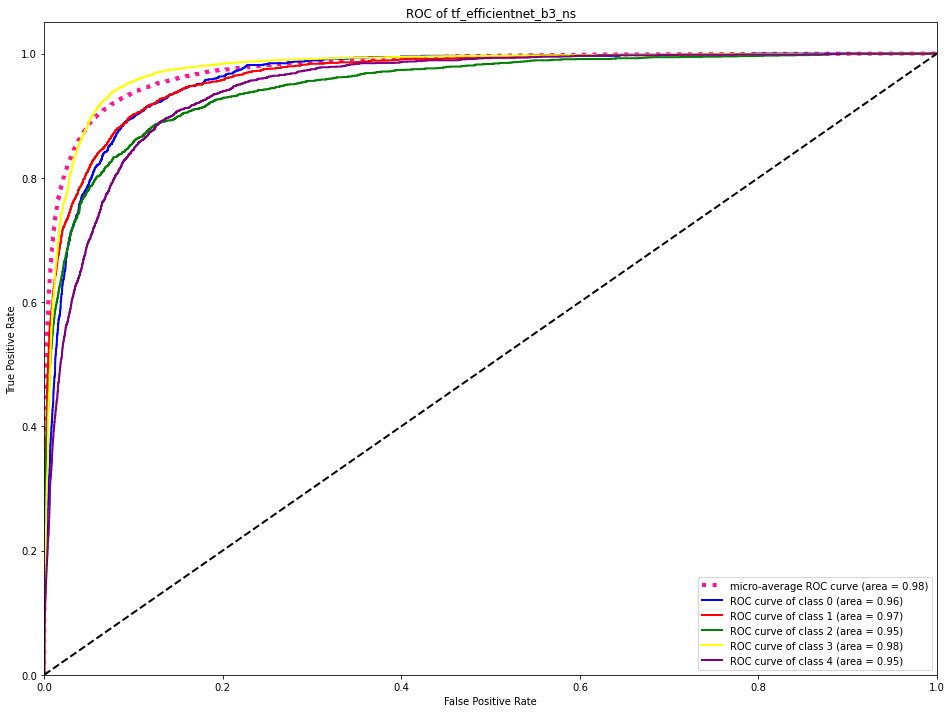

In [180]:
from sklearn.preprocessing import OneHotEncoder

# Convert labels to one-hot encoded format
encoder = OneHotEncoder(categories='auto')
ytrue_onehot = encoder.fit_transform(ytrue.reshape(-1, 1)).toarray()

# Call the plot_roc_curve function
plot_roc_curve(ytrue_onehot, prob0, prob1, prob2, prob3, prob4, ypred)